Setup

In [1]:
import numpy as np
import pandas as pd
import os
from itertools import product
import scanpy as sc
import liana as li

import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
# tight layout by default
plt.rcParams.update({'figure.autolayout': True})

from utils import *

In [2]:
li.__version__

'1.0.5'

In [3]:
path = os.path.join('..', '..', 'data', 'slidetags')

In [4]:
[method.method_name for method in li.mt.rank_aggregate.methods]

['CellPhoneDB', 'Connectome', 'log2FC', 'NATMI', 'SingleCellSignalR']

In [5]:
from liana.method import cellphonedb, connectome, cellchat, scseqcomm, singlecellsignalr, natmi, logfc, rank_aggregate, geometric_mean
methods = [cellphonedb, connectome, cellchat, scseqcomm, singlecellsignalr, natmi, logfc, rank_aggregate, geometric_mean]

In [6]:
groupby = 'cell_type'

In [7]:
d = {
     # 'SCP2162': 'mousehippocampus', # NOTE barcodes between metadata and matrix do not match; also very few spatially-matched
     'SCP2167': 'humancortex',
     'SCP2169': 'HumanTonsil',
     'SCP2170': 'mouseembryo',
     'SCP2171': 'HumanMelanomaRNA',
     'SCP2176': 'HumanMelanomaMultiome'
     }

Prep Data & Run LIANA

In [8]:
for k, v in d.items():
    adata = sc.read_10x_mtx(os.path.join(path, f'{k}/expression/counts/'))
    spatial = pd.read_csv(os.path.join(path, f"{k}/cluster/{v}_spatial.csv")).iloc[1:].set_index("NAME")
    
    print(k, v, adata.shape)
    
    # NOTE: keep only cells that are in the spatial data
    adata = adata[adata.obs.index.isin(spatial.index)]
    adata.obs = adata.obs.merge(spatial, left_index=True, right_index=True)
    # remove _ from cell types
    adata.obs['cell_type'] = adata.obs['cell_type'].str.replace('_', '-')
    
    adata.obsm = {}
    adata.obsm['spatial'] = adata.obs[['X', 'Y']].values.astype(np.float32)
    
    # Filter and normalize
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    
    adata.layers['raw'] = adata.X.copy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    
    if v.__contains__("mouse"):
        resource_name = 'mouseconsensus'
    else:
        resource_name = 'consensus'
    
    # Run Methods
    for method in methods:
        if method.method_name != 'Rank_Aggregate':
            kw = {'supp_columns': ['ligand_pvals', 'receptor_pvals']}
        else:
            kw = {}
        
        adata.uns[method.method_name] = method(adata,
                                               groupby=groupby,
                                               use_raw=False,
                                               verbose=False,
                                               n_perms=1000,
                                               n_jobs=10,
                                               inplace=False,
                                               resource_name = resource_name,
                                               **kw
                                               )
    
    adata.write_h5ad(os.path.join(path, k, "adata.h5ad"))

SCP2167 humancortex (14165, 36601)


... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'cell_type' as categorical
... storing 'feature_types' as categorical


SCP2169 HumanTonsil (9360, 36601)


... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'cell_type' as categorical
... storing 'feature_types' as categorical


SCP2170 mouseembryo (9037, 32285)


/home/dbdimitrov/.local/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/home/dbdimitrov/.local/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/home/dbdimitrov/.local/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:401: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all

SCP2171 HumanMelanomaRNA (6466, 36601)


... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'cell_type' as categorical
... storing 'feature_types' as categorical


SCP2176 HumanMelanomaMultiome (5704, 36601)


... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'cell_type' as categorical
... storing 'feature_types' as categorical


Generate Truth

In [9]:
for k, v in d.items():
    adata = sc.read_h5ad(os.path.join(path, k, "adata.h5ad"))
    
    if v.__contains__("mouse"):
        resource_name = 'mouseconsensus'
    else:
        resource_name = 'consensus'
    
    # Run LR
    li.ut.spatial_neighbors(adata, bandwidth=150, cutoff=0.1, set_diag=True)
    li.mt.lr_bivar(adata, 
               function_name="morans",
               inplace=True,
               use_raw=False, 
               n_perms=0,
               expr_prop=0.05,
               verbose=True,
               mask_negatives=True,
               resource_name=resource_name
               )
    lrdata = adata.obsm['local_scores']
    lrdata.write_h5ad(os.path.join(path, k, "lrdata.h5ad"))
    
    # Run CP; NOTE: I'm currently discarding autocrine, and only evaluating para/ortho
    ctdata = onehot_groupby(adata, groupby='cell_type')
    interactions = list(product(ctdata.var.index, ctdata.var.index))
    
    li.mt.lr_bivar(ctdata, 
               function_name="morans",
               inplace=True,
               use_raw=False,
               expr_prop=0,
               n_perms=0,
               verbose=True,
               mask_negatives=True,
               interactions=interactions,
               )
    cpdata = ctdata.obsm['local_scores']
    cpdata.write_h5ad(os.path.join(path, k, "cpdata.h5ad"))

Using resource `consensus`.
Using `.X`!
... storing 'ligand' as categorical
... storing 'receptor' as categorical
/home/dbdimitrov/miniconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
Using provided `interactions`.
Using `.X`!
Make sure that normalized counts are passed!
Removing 7 self-interactions
... storing 'ligand' as categorical
... storing 'receptor' as categorical
Using resource `consensus`.
Using `.X`!
... storing 'ligand' as categorical
... storing 'receptor' as categorical
/home/dbdimitrov/miniconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
Using provided `interactions`.
Using `.X`!
Make sure that normalized counts are passed!
Removing 13 self-interactions
... storing 'ligand' as categorical
... storing 'receptor' as categorical
Using resource `mouseconsensus`.
Using `.X`!
... storing 'ligand' as categorica

## Evaluate

In [10]:
# define custom filter functions
lambdas = {}
lambdas['CellPhoneDB'] = lambda x: x['cellphone_pvals'] < 0.05
lambdas['Connectome'] = lambda x: ((x['ligand_pvals'] < 0.05) & (x['receptor_pvals'] < 0.05) & (x['scaled_weight'] > 0))
lambdas['log2FC'] = lambda x: ((x['ligand_pvals'] < 0.05) & (x['receptor_pvals'] < 0.05) & (x['lr_logfc'] > 0))
# top 5% of ligand-receptor pairs
lambdas['NATMI'] = lambda x: ((x['spec_weight'] > np.quantile(gt['spec_weight'], 0.95))) # NOTE gt
lambdas['SingleCellSignalR'] = lambda x: (x['lrscore'] > 0.6)
lambdas['Rank_Aggregate'] = lambda x: ((x['magnitude_rank'] < 0.05) & (x['specificity_rank'] < 0.05))
lambdas['Geometric Mean'] = lambda x: (x['gmean_pvals'] < 0.05)
lambdas['scSeqComm'] = lambda x: ((x['inter_score'] > 0.95))
lambdas['CellChat'] = lambda x: ((x['cellchat_pvals'] < 0.05) & (x['ligand_pvals'] < 0.05) & (x['receptor_pvals'] < 0.05))

In [11]:
prop_range = [0.01, 0.05, 0.1, 0.2, 0.5]
eval_results = pd.DataFrame(columns=['Dataset',
                                     'Method',
                                     'Score',
                                     'AUROC',
                                    #  'Odds',
                                    #  'AUPRC',
                                     "Balanced Accuracy",
                                     'Precision',
                                     "Recall",
                                     "F1",
                                     "F1*",
                                     "F1 (normalised)",
                                     "F1* (normalised)",
                                     "Positive Calls"
                                     ])
scores = li.mt.show_methods()

# Run Methods & Evaluate
for k, v in d.items():
    adata = sc.read_h5ad(os.path.join(path, f"{k}/adata.h5ad"))
    lrdata = sc.read_h5ad(os.path.join(path, f"{k}/lrdata.h5ad"))
    cpdata = sc.read_h5ad(os.path.join(path, f"{k}/cpdata.h5ad"))
    
    for method in methods:
        method_name = method.method_name        
        score_keys = scores[scores['Method Name'] == method.method_name]
        lr_res = adata.uns[method_name].copy()

        score_keys = score_keys[['Magnitude Score', 'Specificity Score']].values[0]
        # if None in score_keys, remove it
        score_keys = [s for s in score_keys if s is not None]
        
        gt = join_pred_truth(lr_res, lrdata, cpdata)
        gt['binary'] = gt.apply(lambdas[method_name], axis=1).astype(int)
        
        f1 = calc_weighted_f1(gt, score_key='binary', average='binary')
        f1_baseline = generate_random_baseline(gt, score_key='binary',
                                               metric_fun=calc_weighted_f1, 
                                               average='binary')
        f1_norm = (f1/f1_baseline) / 2
        print(f"__{method_name}; f1:{round(f1, 2)}; f1_norm:{round(f1_norm, 2)}")
        
        acc = calc_accuracy(gt, score_key='binary')
        
        precision = calc_precision(gt, score_key='binary')
        recall = calc_recall(gt, score_key='binary')
        # n times positive calls / total calls
        call_ratio = gt['binary'].sum() / gt.shape[0]

        for score_key in score_keys:
            gt = li.method.process_scores(gt, score_key=score_key)
            # odds = [odds_ratio(gt, score_key=score_key, top_prop=prop) for prop in prop_range]
            auroc = calc_auroc(gt, score_key=score_key, show_plot=False)
            # auprc = calc_auprc(gt, score_key=score_key, show_plot=False)
            
            # capped F1 - i.e. all scores are evaluated at the same threshold (not really possible due to ties)
            gt['cap'] = (gt[score_key] >= np.quantile(gt[score_key], 0.95)).astype(int)
            
            f1_cap = calc_weighted_f1(gt, score_key='cap', average='binary')
            f1_baseline = generate_random_baseline(gt, score_key='cap',
                                                   metric_fun=calc_weighted_f1, 
                                                   average='binary')
            f1_cnorm = (f1_cap / f1_baseline) / 2
            
            # NOTE: f1 and acc are calculated above - i.e. once per method
            eval_results.loc[len(eval_results)] = [v, method_name, score_key,
                                                   auroc,
                                                   # odds,  auprc,
                                                   acc, precision, recall,
                                                   f1, f1_cap,
                                                   f1_norm, f1_cnorm,
                                                   call_ratio]

__CellPhoneDB; f1:0.25; f1_norm:0.6
__Connectome; f1:0.23; f1_norm:0.57
__CellChat; f1:0.2; f1_norm:0.67
__scSeqComm; f1:0.21; f1_norm:0.48
__SingleCellSignalR; f1:0.22; f1_norm:0.49
__NATMI; f1:0.13; f1_norm:0.91
__log2FC; f1:0.23; f1_norm:0.6
__Rank_Aggregate; f1:0.08; f1_norm:0.89
__Geometric Mean; f1:0.25; f1_norm:0.59
__CellPhoneDB; f1:0.29; f1_norm:0.49
__Connectome; f1:0.22; f1_norm:0.42
__CellChat; f1:0.16; f1_norm:0.44
__scSeqComm; f1:0.32; f1_norm:0.51
__SingleCellSignalR; f1:0.34; f1_norm:0.5
__NATMI; f1:0.08; f1_norm:0.53
__log2FC; f1:0.2; f1_norm:0.43
__Rank_Aggregate; f1:0.03; f1_norm:0.4
__Geometric Mean; f1:0.28; f1_norm:0.48
__CellPhoneDB; f1:0.21; f1_norm:0.56
__Connectome; f1:0.18; f1_norm:0.61
__CellChat; f1:0.15; f1_norm:0.65
__scSeqComm; f1:0.21; f1_norm:0.52
__SingleCellSignalR; f1:0.22; f1_norm:0.51
__NATMI; f1:0.13; f1_norm:0.93
__log2FC; f1:0.17; f1_norm:0.64
__Rank_Aggregate; f1:0.05; f1_norm:0.6
__Geometric Mean; f1:0.21; f1_norm:0.58
__CellPhoneDB; f1:0.21;

In [12]:
eval_results.to_csv("evals_results.csv")

Visualize

In [4]:
res = pd.read_csv("evals_results.csv")
res.head()

,Unnamed: 0,Dataset,Method,Score,AUROC,Balanced Accuracy,Precision,Recall,F1,F1*,F1 (normalised),F1* (normalised),Positive Calls
0,0,humancortex,CellPhoneDB,lr_means,0.535669,0.562070,0.150743,0.670802,0.246168,0.105450,0.597642,0.726768,0.562350
1,1,humancortex,CellPhoneDB,cellphone_pvals,0.566376,0.562070,0.150743,0.670802,0.246168,0.247706,0.597642,0.613347,0.562350
2,2,humancortex,Connectome,expr_prod,0.525790,0.539253,0.145081,0.531844,0.227974,0.114929,0.573319,0.797829,0.463259
3,3,humancortex,Connectome,scaled_weight,0.561014,0.539253,0.145081,0.531844,0.227974,0.082938,0.573319,0.584600,0.463259
4,4,humancortex,CellChat,lr_probs,0.541922,0.537693,0.170049,0.256410,0.204485,0.116114,0.666495,0.815037,0.190551


In [5]:
# replace expr_prod with Product* when Method is Connectome
res.loc[(res['Score'] == 'expr_prod') & (res['Method'] == 'Connectome'), 'Score'] = 'Product*'
res.loc[(res['Score'] == 'expr_prod') & (res['Method'] == 'NATMI'), 'Score'] = 'Product✳'

In [6]:
# Assuming 'res' is already loaded as a pandas DataFrame
# Replace underscores with spaces and title case 'Score'
res['Score'] = res['Score'].str.replace('_', ' ').str.title()

# Convert 'Score' to a categorical type with ordered categories
score_order = res.sort_values("Method")['Score'].unique()
res['Score'] = pd.Categorical(res['Score'], categories=score_order, ordered=True)
res['Method'] = pd.Categorical(res['Method'], categories=res['Method'].unique(), ordered=True)

In [19]:
import seaborn as sns
import matplotlib.patches as mpatches

def plot_method_comparison(res, metric, baseline=None, limits=(0,1), x="Score", show_legend=False, figsize=(5, 5), ax=None):
    # If no axis is provided, create a new figure and axis
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    # Create a color palette
    palette = sns.color_palette("Set1", n_colors=res['Method'].nunique())

    # Plot each 'Method' group with a different color on the provided axis
    method_order = res['Method'].unique()
    sns.boxplot(x=x, y=metric, data=res, hue='Method', hue_order=method_order, palette=palette, dodge=False, width=0.8, ax=ax,
                medianprops=dict(color="cyan"))

    # To remove the hue legend from the axis
    if show_legend:
        # This assumes 'palette' and 'method_order' are defined as before in the function
        legend_patches = [mpatches.Patch(color=palette[i], label=method) for i, method in enumerate(method_order)]
        # Position the legend outside the plot to the right
        ax.legend(handles=legend_patches, title='Method', loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    else:
        ax.legend([], [], frameon=False)

    # Set limits for the y-axis on the provided axis
    ax.set_ylim(limits)

    # Set the y-axis labels to two decimals on the provided axis
    ax.set_yticklabels(['{:.2f}'.format(y) for y in ax.get_yticks()])

    # Draw a horizontal line at the baseline if provided, on the provided axis
    if baseline is not None:
        ax.axhline(y=baseline, color='red', linestyle='dashed', linewidth=1.5)

    # Set the axis label
    ax.set_ylabel(metric, fontsize=14)
    ax.set_xlabel('', fontsize=14)
    
    # Rotate the x-axis labels on the provided axis
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

    # If a separate figure was created (i.e., ax was None), show the plot
    if ax is None:
        plt.tight_layout()
        plt.show()

/tmp/ipykernel_280474/2530076638.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
/tmp/ipykernel_280474/2530076638.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
/tmp/ipykernel_280474/2530076638.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
/tmp/ipykernel_280474/2530076638.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


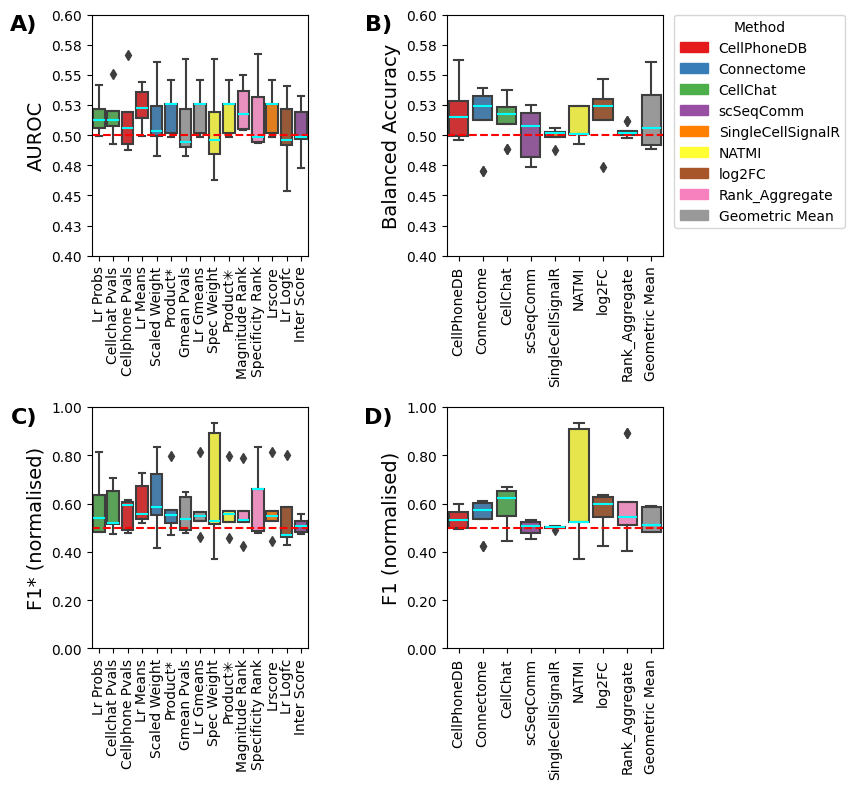

In [20]:
import matplotlib.gridspec as gridspec

# Create a figure
fig = plt.figure(figsize=(10.75, 8))

# Define a 2x2 grid
gs = gridspec.GridSpec(2, 2)

# Top row with one plot aligned to the right
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
# ax4 = fig.add_subplot(gs[2, 0])
# ax5 = fig.add_subplot(gs[2, 1])

# Use the plot_method_comparison function with these axes
# Example usage (you will replace 'res', 'metric', etc. with your actual data and parameters)
plot_method_comparison(res, metric='AUROC', x="Score", baseline=0.5, limits=(0.4, 0.6), figsize=(7, 5), ax=ax0)
plot_method_comparison(res, metric='Balanced Accuracy', x="Method", limits=(0.4, 0.6), figsize=(5, 5), baseline=0.5, ax=ax1, show_legend=True)
plot_method_comparison(res, metric='F1* (normalised)', x="Score", limits=(0, 1), figsize=(5, 5), ax=ax2, baseline=0.5)
plot_method_comparison(res, metric='F1 (normalised)', x="Method", figsize=(5, 5), ax=ax3, limits=(0, 1), baseline=0.5)

# plot_method_comparison(res, metric='F1', x="Method", limits=(0, 0.3), figsize=(5, 5), ax=ax3)
# plot_method_comparison(res, metric='F1*', x="Score", limits=(0, 0.3), figsize=(7, 5), ax=ax1, show_legend=True)

# Add labels A)-F)
labs = ['A)', 'B)', 'C)', 'D)'] # , 'E)', 'F)'
for i, ax in enumerate([ax0,ax1, ax2, ax3]): #  , ax4, ax5
    ax.text(-0.25, 1.00, labs[i], transform=ax.transAxes, fontsize=16, va='top', ha='right', fontweight='bold')

# Show the plot
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig("../../figures/slidetags_eval.pdf")
plt.show()

In [18]:
from scipy.stats import spearmanr
metrics = ['AUROC', 'Balanced Accuracy', "Precision", "Recall", 'F1', 'F1*', 'F1 (normalised)', 'F1* (normalised)']
for metric in metrics:
    # correlate with positive calls
    corr, pval = spearmanr(res['Positive Calls'], res[metric])
    print(f"{metric}: {round(corr, 3)}; {round(pval, 5)}")

AUROC: 0.057; 0.62834
Balanced Accuracy: 0.064; 0.58301
Precision: -0.222; 0.05585
Recall: 0.989; 0.0
F1: 0.765; 0.0
F1*: 0.191; 0.10091
F1 (normalised): -0.281; 0.01445
F1* (normalised): -0.037; 0.75049
